<!--NOTEBOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="./figures/LogoOpenclassrooms.png">
<font size="4">
<p>
Cette activité est réalisée dans le cadre du cours ``Analysez vos données textuelles`` diffusé en MOOC par
<font color='blus'>Openclassrooms</font>.
</p>
...   
<p>
...   
</p>

**Consignes**: 

* Charger les données
* Créer différents classifieurs (au moins 3)
* Effectuer une validation croisée sur les différents classifieurs
* Afficher les différentes performances

<p>
Le jeu de données est relativement lourd pour un travail en local, avec 650MB compressé de données. Il est conseillé de travailler sur un échantillon dans un premier temps pour s’assurer que tout fonctionne comme prévu pour ensuite traiter tout le jeu de données et obtenir les résultats finaux.    
</p>

In [1]:
#-------------------------------------------------------------------------------
# Constants for this notebook
#-------------------------------------------------------------------------------
file_name_train = './data/rcv1_train.dump'
IS_LOCAL_DATASET=True
IS_LOCAL_DATASET_TEST=False

N_JOBS=-1

#-------------------------------------------------------------------------------
# Those ratio for dimensioning X and y vectors.
#-------------------------------------------------------------------------------
train_ratio = 0.7
test_ratio = 0.01

In [2]:
import numpy as np

from sklearn import preprocessing
from sklearn import metrics


#-------------------------------------------------------------------------------
#
#-------------------------------------------------------------------------------
def X_y_ratio(X,y,train_ratio):
    train_range= int(X.shape[0]*train_ratio)
    X_ratio=X[:train_range]
    y_ratio=y[:train_range]
    
    return X_ratio, y_ratio
#-------------------------------------------------------------------------------


import matplotlib.pyplot as plt

#-------------------------------------------------------------------------------
#
#-------------------------------------------------------------------------------
def ser_item_occurency_plot(ser_item_name, ser_item_count, item_count=None, title=None):
    """Plot values issued form 2 Series as following : 
    First Series contains items names
    Second Series contains items occutencies.
    
    """
    df_item_dict={item:count for item, count \
    in zip(ser_item_name, ser_item_count)}

    list_item_sorted \
    = sorted(df_item_dict.items(), key=lambda x: x[1], reverse=False)

    dict_item_sorted = dict()
    for tuple_value in list_item_sorted :
        dict_item_sorted[tuple_value[0]] = tuple_value[1]


    X = list(dict_item_sorted.keys())
    y = list(dict_item_sorted.values())

    fig, ax = plt.subplots(figsize=(20,10))

    if item_count is not None:
        X_plot = X[:item_count]
        y_plot = y[:item_count]
    else:
        X_plot = X.copy()
        y_plot = y.copy()
    
    ax.plot(X_plot,y_plot)
    ax.set_xticklabels(X[:item_count], rotation=90)
    ax.set_xlabel('Accuracy')
    ax.set_ylabel('Classifiers')
    if title is not None : 
        ax.set_title(title)
    ax.grid(linestyle='-', linewidth='0.1', color='grey')
    fig.patch.set_facecolor('#E0E0E0')

    plt.show()
#-------------------------------------------------------------------------------


# <font color='blus'>1. Data acquisition</font>

**From http://scikit-learn.org/stable/datasets/rcv1.html**

``data``: The feature matrix is a scipy CSR sparse matrix, with 804414 samples and 47236 features. 

Non-zero values contains cosine-normalized, log TF-IDF vectors. 

A nearly chronological split is proposed in [1]: 

* The first 23149 samples are the training set. 
* The last 781265 samples are the testing set. 

This follows the official LYRL2004 chronological split. 

The array has 0.16% of non zero values:

## <font color='blus'>1.1. Loading train dataset </font>

In [3]:
# RCV1 : Reuters Corpus Volume I 
from sklearn.datasets import fetch_rcv1

import p5_util

if IS_LOCAL_DATASET is False:
    #------------------------------------------------------------------------
    # Loading train dataset
    #------------------------------------------------------------------------
    rcv1_train = fetch_rcv1(subset='train')
    file_name = file_name_train
    #------------------------------------------------------------------------
    # Dumping train dataset
    #------------------------------------------------------------------------
    p5_util.object_dump(rcv1_train, file_name)
else:
    print("\n*** Loading local train dataset ...")
    print(file_name_train+str("\n"))
    rcv1_train = p5_util.object_load(file_name_train)
    print("\n*** Local train dataset loaded!")

print("\n*** Train target : "+str(rcv1_train.target_names.shape))
print("\n*** Train data : "+str(rcv1_train.data.shape))

X_train = rcv1_train.data
y_train = rcv1_train.target
del(rcv1_train)


*** Loading local train dataset ...
./data/rcv1_train.dump

p5_util.object_load : fileName= ./data/rcv1_train.dump

*** Local train dataset loaded!

*** Train target : (103,)

*** Train data : (23149, 47236)


## <font color='blus'>1.2. Loading test dataset from corpus</font>

In [4]:
import p5_util

data_path = "./data"
core_name = "rcv1_test"

# RCV1 : Reuters Corpus Volume I 
from sklearn.datasets import fetch_rcv1
data_path = "./data"
core_name = "rcv1_test"

if IS_LOCAL_DATASET_TEST is False:
    #------------------------------------------------------------------------
    # Loading test dataset
    #------------------------------------------------------------------------
    rcv1_test = fetch_rcv1(subset='test')
    print(rcv1_test.keys(),rcv1_test.data.shape)
    
    #------------------------------------------------------------------------
    # Dumping test dataset
    #------------------------------------------------------------------------
    p5_util.bunch_dump(rcv1_test, 100000, data_path, core_name)    
else:
    print("\n*** Loading local test dataset ...")
    list_key = ['data', 'target', 'sample_id', 'target_names',]
    data_len=781265
    row_packet=100000
    dict_rcv1_test = p5_util.bunch_load(list_key, data_len, row_packet, data_path, core_name)
    print("\n*** Local test dataset loaded!")

print("\n*** Test dataset dictionary keys : "+str(dict_rcv1_test.keys()))
print("\n*** Test target sizing : "+str(dict_rcv1_test['target_names'].shape))
print("\n*** Test data sizing : "+str(dict_rcv1_test['data'].shape))

X_test = dict_rcv1_test['data']
y_test = dict_rcv1_test['target']
del(dict_rcv1_test)


*** Loading local test dataset ...
p5_util.object_load : fileName= ./data/rcv1_test_data_0.dump
./data/rcv1_test_data_0.dump (100000, 47236)
p5_util.object_load : fileName= ./data/rcv1_test_data_1.dump
./data/rcv1_test_data_1.dump (200000, 47236)
p5_util.object_load : fileName= ./data/rcv1_test_data_2.dump
./data/rcv1_test_data_2.dump (300000, 47236)
p5_util.object_load : fileName= ./data/rcv1_test_data_3.dump
./data/rcv1_test_data_3.dump (400000, 47236)
p5_util.object_load : fileName= ./data/rcv1_test_data_4.dump
./data/rcv1_test_data_4.dump (500000, 47236)
p5_util.object_load : fileName= ./data/rcv1_test_data_5.dump
./data/rcv1_test_data_5.dump (600000, 47236)
p5_util.object_load : fileName= ./data/rcv1_test_data_6.dump
./data/rcv1_test_data_6.dump (700000, 47236)
p5_util.object_load : fileName= ./data/rcv1_test_data_7.dump
./data/rcv1_test_data_7.dump (781258, 47236)

 Loading splited file done!

p5_util.object_load : fileName= ./data/rcv1_test_target_0.dump
./data/rcv1_test_target

In [5]:
print(X_test.shape, y_test.shape)
X_test, y_test = X_y_ratio(X_test, y_test, test_ratio)
print(X_test.shape, y_test.shape)

(781258, 47236) (781258, 103)
(7812, 47236) (7812, 103)


In [6]:
print(X_train.shape, y_train.shape)
X_train, y_train = X_y_ratio(X_train, y_train, train_ratio)
print(X_train.shape, y_train.shape)

(23149, 47236) (23149, 103)
(16204, 47236) (16204, 103)


# <font color='blus'>2. Applying classifiers over dataset</font>

**Classsifiers score are stored into dictionary**

In [ ]:
dict_classifer_score=dict()

## <font color='blus'>2.1. Multinomial Naive Bayes classifier with binary relevance</font>

Due to multiple targets classes, `OneVsRestClassifier` classifier is applied on Multinomial Naive Bayes classifier. 

One classifier per class is fitted.

**Note : change N_JOBS value if required. Default value is fixed to 8.** 

*See constants assignation into fisrt cells from this notebook.*

### <font color='blus'>2.1.1. Training Multinomial Naive Bayes classifier</font>

One versus Rest transformation ispallied Naive Bayes classifier.

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier

classifier_mnb = OneVsRestClassifier(MultinomialNB()).fit(X_train, y_train)

### <font color='blus'>2.1.2. Classifier evaluation </font>

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = classifier_mnb.predict(X_test)

classifier_mnb_score = accuracy_score(y_test,y_pred)

print("Accuracy score for MNB classifier composed with OvR: {0:1.2F} %".format(classifier_mnb_score*100))

In [ ]:
dict_classifer_score['MNB'] = classifier_mnb_score

In [ ]:
import p5_util
file_name='./data/dict_classifer_score.dump'
p5_util.object_dump(dict_classifer_score, file_name)

## <font color='blus'>2.2. Chained Multinomial Naive Bayes classifier</font>

### <font color='blus'>2.2.1. Training Chained Naive Bayes classifier</font>

In [ ]:
#from nltk.classify import NaiveBayesClassifier
#from sklearn.multioutput import ClassifierChain
from skmultilearn.problem_transform import ClassifierChain

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression


In [ ]:
chained_classifier_mnb = ClassifierChain(MultinomialNB())

In [ ]:
chained_classifier_mnb.fit(X_train , y_train)

In [ ]:
import p5_util
file_name='./data/chained_classifier_mnb.dump'
p5_util.object_dump(chained_classifier_mnb, file_name)

In [ ]:
import p5_util
file_name='./data/dict_classifer_score.dump'
p5_util.object_dump(dict_classifer_score, file_name)

### <font color='blus'>2.2.2. Chained classifier evaluation </font>

In [ ]:
import p5_util
file_name='./data/chained_classifier_mnb.dump'
chained_classifier_mnb = p5_util.object_load(file_name)

file_name='./data/dict_classifer_score.dump'
dict_classifer_score = p5_util.object_load(file_name)


In [ ]:
chained_classifier_mnb_score = chained_classifier_mnb.score(X_test ,y_test)

print("Mean score for Chained Multinomial Naive Bayes classifier : {0:1.2F} %".format(chained_classifier_mnb_score*100))

from sklearn.metrics import accuracy_score
y_pred = classifier_mnb_chained.predict(X_test_size)

chained_classifier_mnb_score = accuracy_score(y_test,y_pred)

print("Accuracy score for chained MNB classifier : {0:1.2F} %".format(score*100))

This result is not better then the one with OvR (binary relevance) transformation.

It then can be suspected that Labels are independants from each other.

In [ ]:
dict_classifer_score['Chained MNB'] = chained_classifier_mnb_score

In [ ]:
import p5_util
file_name='./data/dict_classifer_score.dump'
p5_util.object_dump(dict_classifer_score, file_name)

## <font color='blus'>2.3. Evaluation of Multinomial Bernouilli Naive Bayes classifier</font>

Data have binaries values? Bernouilli naive Bayes classifier is expected to provide good results.

It is revealed that `y_train` is encoded as a binary array.

It is then possible to arrange classifier as chained Binaries classifiers.

Chaining binaries classifiers leads to take into account correlations between Labels assigned to samples.


### <font color='blus'>2.3.1. Training classifier</font>

In [ ]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.multiclass import OneVsRestClassifier

classifier_ber = OneVsRestClassifier(BernoulliNB(), n_jobs=N_JOBS).fit(X_train, y_train)

### <font color='blus'>2.3.2. Classifier evaluation </font>

In [ ]:
import p5_util
file_name='./data/dict_classifer_score.dump'
dict_classifer_score = p5_util.object_load(file_name)
dict_classifer_score

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = classifier_ber.predict(X_test)

classifier_ber_score = accuracy_score(y_test,y_pred)

print("Accuracy score for Bernoilli NB classifier : {0:1.2F} %".format(classifier_ber_score*100))

In [ ]:
dict_classifer_score['Bernouilli NB'] = classifier_ber_score

In [ ]:
import p5_util
file_name='./data/dict_classifer_score.dump'
p5_util.object_dump(dict_classifer_score, file_name)

## <font color='blus'>2.4. Evaluation of SGD classifier</font>

Stochastic Gradient Descent Classifier

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier

classifier_sgd = OneVsRestClassifier(SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None)).fit(X_train, y_train)

In [ ]:
classifier_sgd_score = classifier_sgd.score(X_test ,y_test)
print("Mean score for Stochastic Gradient Descent classifier : {0:1.2F} %".format(classifier_sgd_score*100))

In [ ]:
dict_classifer_score['SGD'] = classifier_sgd_score

In [ ]:
import p5_util
file_name='./data/dict_classifer_score.dump'
p5_util.object_dump(dict_classifer_score, file_name)

## <font color='blus'>2.5. Chained evaluation of SGD classifier</font>

Stochastic Gradient Descent Classifier.

Ce classifier declenche une erreur car li existe un cas ou une 
observation a seulement 1 classe.

On va éliminer ces cas pour éviter une exception.

In [ ]:
from sklearn.linear_model import SGDClassifier
from skmultilearn.problem_transform import ClassifierChain

#
chained_classifier_sgd = ClassifierChain(SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None))

**Rows with less then 1 class are filtered from X_train and y_train**

In [11]:
dict_class_y = dict()
dict_class_X = dict()

print(X_train.shape, y_train.shape)

for i in range(0,len(y_train.toarray())):
    if y_train[i].toarray().sum() > 1:
        #dict_class_1[i]= y_train[i].toarray().sum()
        dict_class_y[i] = y_train[i]
        dict_class_X[i] = X_train[i]
len(dict_class_y), len(dict_class_X)

(15703, 47236) (15703, 103)


(15703, 15703)

In [10]:
from scipy import sparse

y_train_cleaned  = np.take(y_train.toarray(), [key for key in dict_class_y.keys()], axis=0, out=None, mode='raise')
y_train = sparse.csr_matrix(y_train_cleaned)
del(y_train_cleaned)

X_train_cleaned  = np.take(X_train.toarray(), [key for key in dict_class_y.keys()], axis=0, out=None, mode='raise')
X_train = sparse.csr_matrix(X_train_cleaned)
del(X_train_cleaned)

X_train.shape, y_train.shape

((15703, 47236), (15703, 103))

In [ ]:
chained_classifier_sgd.fit(X_train , y_train)

In [ ]:
chained_classifier_sgd_score = classifier_sgd.score(X_test ,y_test)
print("Mean score for Stochastic Gradient Descent classifier : {0:1.2F} %".format(chained_classifier_sgd_score*100))

In [ ]:
import p5_util
dict_classifer_score['Chained SGD'] = chained_classifier_sgd_score
file_name='./data/dict_classifer_score.dump'
p5_util.object_dump(dict_classifer_score, file_name)

## <font color='blus'>2.5. SGD classfier transformed with Label powerset</font>

### <font color='blus'>2.5.1. Training classifier</font>

In [27]:
from sklearn.linear_model import SGDClassifier
from skmultilearn.problem_transform import LabelPowerset
power_classifier_sgd = LabelPowerset(SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None))

In [28]:
power_classifier_sgd.fit(X_train , y_train)

LabelPowerset(classifier=SGDClassifier(alpha=0.001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
       require_dense=[True, True])

In [30]:
from sklearn.metrics import accuracy_score
y_pred = power_classifier_sgd.predict(X_test)

power_classifier_sgd_score = accuracy_score(y_test,y_pred)

print("Accuracy score for Power labelled SGD classifier : {0:1.2F} %".format(power_classifier_sgd_score*100))

Accuracy score for Power labelled SGD classifier : 48.31 %


In [35]:
dict_classifer_score

{'MNB': 0.062848,
 'Chained MNB': 0.102208,
 'Bernouilli NB': 0.146112,
 'SGD': 0.197696,
 'Logistic Regression': 0.3429281029102719,
 'Power SGD': 0.48310291858678955}

In [34]:
import p5_util
dict_classifer_score['Power SGD'] = power_classifier_sgd_score
file_name='./data/dict_classifer_score.dump'
p5_util.object_dump(dict_classifer_score, file_name)

## <font color='blus'>2.6. Logistic regression & One vs rest</font>

In [16]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer

dict_param_grid = {
    'estimator__C': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0],
    'estimator__penalty': ['l2'],
    'n_jobs': [-1]
}

estimator = OneVsRestClassifier(LogisticRegression())
lr_gscv  = GridSearchCV(estimator, dict_param_grid)

In [17]:
lr_gscv.fit(X_train, y_train)

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 42 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 49 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 66 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/l

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
          n_jobs=None),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'estimator__C': [1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0], 'estimator__penalty': ['l2'], 'n_jobs': [-1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [18]:
print (lr_gscv.best_score_)
print (lr_gscv.best_params_)

0.3429281029102719
{'estimator__C': 1.0, 'estimator__penalty': 'l2', 'n_jobs': -1}


In [49]:
import p5_util
file_name='./data/dict_classifer_score.dump'
dict_classifer_score = p5_util.object_load(file_name)

dict_classifer_score['GSCV Logistic Regression'] = lr_gscv.best_score_
p5_util.object_dump(dict_classifer_score, file_name)

p5_util.object_load : fileName= ./data/dict_classifer_score.dump


In [51]:
dict_classifer_score

{'MNB': 0.062848,
 'Chained MNB': 0.102208,
 'Bernouilli NB': 0.146112,
 'SGD': 0.197696,
 'Power SGD': 0.48310291858678955,
 'GSCV SGD': 0.5193911991339235,
 'GSCV Logistic Regression': 0.3429281029102719}

In [ ]:
print("Accuracy GSCV Logistic Regression classifier : {0:1.2F} %".format(lr_gscv_score*100))

## <font color='blus'>2.7. Grid search on SGD classifier & One vs rest</font>

In [36]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
dict_param_grid = {
    'estimator__alpha': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0],
    'estimator__penalty': ['l2'],
    'n_jobs': [-1]
}

estimator = OneVsRestClassifier(SGDClassifier())
sgd_gscv  = GridSearchCV(estimator, dict_param_grid, cv=5)


In [37]:
sgd_gscv.fit(X_train, y_train)

/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 42 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 49 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 66 is present in all training examples.
  str(classes[c]))
/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 77 is present in all trainin

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=OneVsRestClassifier(estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
          n_jobs=None),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'estimator__alpha': [1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0], 'estimator__penalty': ['l2'], 'n_jobs': [-1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [1]:
print (sgd_gscv.best_score_)
print (sgd_gscv.best_params_)

NameError: name 'sgd_gscv' is not defined

In [39]:
import p5_util
file_name='./data/dict_classifer_score.dump'
dict_classifer_score = p5_util.object_load(file_name)

dict_classifer_score['GSCV SGD'] = sgd_gscv.best_score_
p5_util.object_dump(dict_classifer_score, file_name)

p5_util.object_load : fileName= ./data/dict_classifer_score.dump


In [40]:
dict_classifer_score

{'MNB': 0.062848,
 'Chained MNB': 0.102208,
 'Bernouilli NB': 0.146112,
 'SGD': 0.197696,
 'Logistic Regression': 0.3429281029102719,
 'Power SGD': 0.48310291858678955,
 'GSCV SGD': 0.5193911991339235}

## <font color='blus'>3. Classifiers results</font>

In [52]:
import pandas as pd
df_result = pd.DataFrame.from_dict( dict_classifer_score, orient='index')
df_result.reset_index(inplace=True)
df_result.rename(columns={'index':'Classifier',0:'Score'}, inplace=True)
df_result

,Classifier,Score
0,MNB,0.062848
1,Chained MNB,0.102208
2,Bernouilli NB,0.146112
3,SGD,0.197696
4,Power SGD,0.483103
5,GSCV SGD,0.519391
6,GSCV Logistic Regression,0.342928


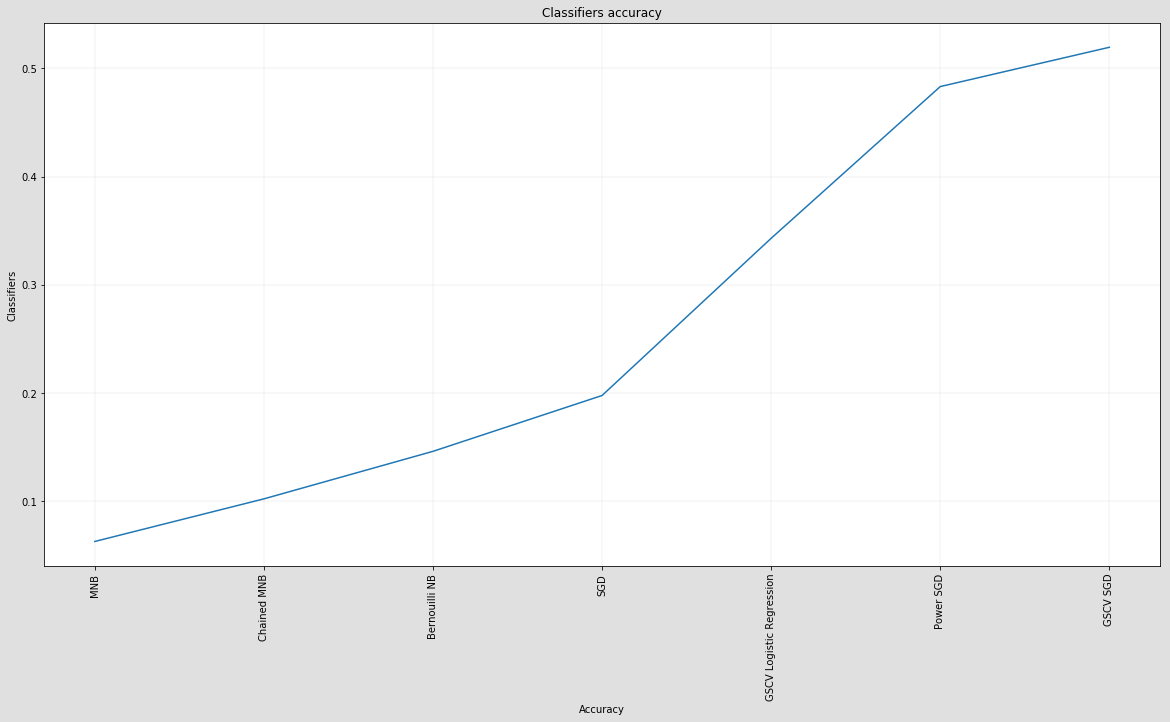

In [53]:
title = "Classifiers accuracy"
ser_item_occurency_plot(df_result.Classifier, df_result.Score, item_count=None, title=title)